In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing all the necessary Packages and Libraries

## Installations

In [ ]:
pip install BioPython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.0 MB 4.1 MB/s 


In [ ]:
pip install propy3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 290 kB 4.1 MB/s 


In [ ]:
pip install pyfaidx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 103 kB 5.7 MB/s 
  Created wheel for pyfaidx: filename=pyfaidx-0.7.1-py3-none-any.whl size=27748 sha256=8d8ae80fcb670e7a55cc609e1a0ddb675035d975a98d9fef6dc6aff19d14f948
  Stored in directory: /root/.cache/pip/wheels/1a/d6/99/7334c4d11bfb574e6d6ea706256053b268a12f2127af1cfd40
Successfully built pyfaidx


## Imports for peptide feature extraction

In [ ]:
# Compute protein descriptors
from propy import PyPro
from propy import AAComposition
from propy import CTD

# Build Sequence Object
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Read Fasta File
from pyfaidx import Fasta

# Grouping iterable
from itertools import chain

# Return file path
import glob

/usr/local/lib/python3.7/dist-packages/propy/__init__.py:29: UserWarning: Python 3.6 and Python 3.7 might get deprecated. Please participate in the discussion: https://github.com/MartinThoma/propy3/issues/12
  "Python 3.6 and Python 3.7 might get deprecated. "


## Imports for ML

In [ ]:
# Import necessary packages

import pandas as pd
import numpy as np
import json 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import make_scorer

from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline

# Importing data and Extracting the Features

Each individual protein have unique structural and functional properties, we use Biopython (a free biological computational tool) ProteinAnalysis library, to extract all the necessary features from the sequences. 

## Feature Extraction function

In [ ]:
# Feature Extraction

def ExtractFeaturesFasta(fastafile):
    
    """ The ExtractFeaturesFasta function gets the protein sequence in the Fasta file format.
    The function parse the fasta file, read the sequence as string and extract the peptide features using appropriate packages into the dataframe.
    
    Parameters
    ----------
    fastafile: File containing peptide sequences in FASTA format
    
    Returns
    -------
    allFeatures: The dataframe with extracted features of each peptide.
    allFeaturesName: A dictionary containing each set of name of the features """
    

    new_peptides = []
    for file in glob.glob(fastafile):
      new_peptides.append(file)
    
    for f in new_peptides:
        fa = Fasta(f)
        # empty list to save the features
        listing = []
        
        for seq in fa:
            # Make sure the sequence is a string
            s = str(seq)
            
            # replace the inappropriate peptide sequence to A
            s = s.replace('X','A')
            s = s.replace('x','A')
            s = s.replace('U','A')
            s = s.replace('Z','A')
            s = s.replace('B','A')

            # Calculating primary features
            analysed_seq = ProteinAnalysis(s)
            wt = analysed_seq.molecular_weight()
            arm = analysed_seq.aromaticity()
            instab = analysed_seq.instability_index()
            flex = analysed_seq.flexibility()
            pI = analysed_seq.isoelectric_point()

            # Create list for identity of protein - Name and Seq
            pId = [seq.name, s]

            # create a list for the primary features
            pFeatures = [len(seq), wt, arm, instab, pI]

            # Get Amino Acid Composition (AAC), Composition Transition Distribution (CTD) and Dipeptide Composition (DPC)
            resultAAC = AAComposition.CalculateAAComposition(s)
            resultCTD = CTD.CalculateCTD(s)
            resultDPC = AAComposition.CalculateDipeptideComposition(s)

            # Collect all the features into lists
            aacFeatures = [j for i,j in resultAAC.items()]
            ctdFeatures = [l for k,l in resultCTD.items()]
            dpcFeatures = [n for m,n in resultDPC.items()]
            listing.append(pId + pFeatures + aacFeatures + ctdFeatures + dpcFeatures)
            
        # Collect feature names
        IDname = ['Name','Seq']
        Pname = ['SeqLength','Weight','Aromaticity','Instability','IsoelectricPoint']
        AACname = [i for i,j in resultAAC.items()]
        CTDname = [k for k,l in resultCTD.items()]
        DPCname = [m for m,n in resultDPC.items()]
        feature_names  = []
        feature_names.append(IDname+Pname+AACname+DPCname+CTDname)
        flatten_list = list(chain.from_iterable(feature_names))

        # create dataframe using all extracted features and the names
        allFeatures = pd.DataFrame(listing, columns = flatten_list)

        # creating dictionary containing all set of name of the features
        allFearuresName = {'primary':Pname, 'AAC':AACname, 'CTD':CTDname, 'DPC':DPCname}
       

        return allFeatures, allFearuresName


In [ ]:
negativeDf, negativeFeatureNames = ExtractFeaturesFasta('/content/drive/Shareddrives/Data 240 Data Mining Project/datasets/biofilm.fasta')

print('\n')
print('The shape of the negative peptide dataframe')
print('Number of rows:    ', negativeDf.shape[0])
print('Number of columns: ', negativeDf.shape[1])

pd.set_option('display.max_columns', None)
negativeDf.head()



The shape of the negative peptide dataframe
Number of rows:     134867
Number of columns:  574


Name  \
0      sp|A0A0H2WZ38|GATD_STAAC   
1      sp|A0A0H3PEK7|TLYA_CAMJJ   
2  tr|A0A8I6APJ2|A0A8I6APJ2_RAT   
3          sp|C0HL98|MAC1_MACFV   
4           sp|D4YWD1|TPF_PELSA   

                                                 Seq  SeqLength      Weight  \
0  MHELTIYHFMSDKLNLYSDIGNIIALRQRAKKRNIKVNVVEINETE...        243  27429.6904   
1  MRFDFFVSKRLNISRNKALELIENEEVLLNGKSFKASFDVKNFLEN...        253  29174.5610   
2  MLNKAGVPKLRCARKYFMPHCIQEIMMRRADAMTLSGSAIFDFYFP...         95  11073.0448   
3                                      GFGMALKLLKKVL         13   1417.8439   
4      FLGTINLSLCEEERDADEEERRDEPDESNVEVKKRFFFLSRIFGK         45   5394.8925   

   Aromaticity  Instability  IsoelectricPoint      A       R      N      D  \
0     0.090535    40.526790          5.460602  3.704   4.115  5.350  6.584   
1     0.090909    30.948261          8.727488  4.348   3.162  8.300  5.929   
2     0.126316    60.015895          9.896751  9.474   7.368  2.105  2.105   
3     0.076923    -7.400000         10.302064  7.692   0.000  0.000  0.000   
4     0.111111    63.593333          4.554986  2.222  11.111  4.444  8.889   

       C       E      Q       G      H      I       L       K      M       F  \
0  1.235   9.465  2.469  10.700  2.881  9.877   8.642   8.642  1.235   4.527   
1  1.186   8.300  2.372   4.743  1.186  8.300  15.810  12.648  0.791   5.929   
2  2.105   4.211  4.211   3.158  2.105  5.263   5.263   8.421  6.316   4.211   
3  0.000   0.000  0.000  15.385  0.000  0.000  30.769  23.077  7.692   7.692   
4  2.222  20.000  0.000   4.444  0.000  4.444   8.889   6.667  0.000  11.111   

       P      S      T      W      Y       V     AA     AR     AN     AD  \
0  2.881  2.881  7.407  0.000  4.527   2.881  0.313  0.428  0.259  0.416   
1  0.791  5.534  3.557  0.395  2.767   3.953  0.241  0.490  0.269  0.447   
2  6.316  6.316  2.105  2.105  6.316  10.526  0.232  0.400  0.368  0.421   
3  0.000  0.000  0.000  0.000  0.000   7.692  0.231  0.385  0.385  0.692   
4  2.222  6.667  2.222  0.000  0.000   4.444  0.244  0.467  0.289  0.378   

      AC     AE     AQ     AG     AH     AI     AL     AK     AM     AF  \
0  0.366  0.218  0.412  0.305  0.284  0.128  0.712  0.160  0.329  0.276   
1  0.407  0.146  0.486  0.261  0.253  0.158  0.700  0.142  0.391  0.190   
2  0.284  0.295  0.474  0.326  0.200  0.158  0.779  0.063  0.421  0.274   
3  0.231  0.077  0.692  0.154  0.154  0.231  0.769  0.000  0.538  0.231   
4  0.511  0.111  0.489  0.244  0.267  0.178  0.533  0.289  0.311  0.178   

      AP     AS     AT     AW     AY     AV     RA     RR     RN     RD  \
0  0.395  0.354  0.387  0.259  0.366  0.350  0.284  0.281  0.182  0.198   
1  0.419  0.261  0.470  0.269  0.407  0.229  0.364  0.234  0.147  0.238   
2  0.305  0.316  0.316  0.368  0.284  0.358  0.358  0.138  0.117  0.298   
3  0.231  0.231  0.385  0.385  0.231  0.231  0.538  0.083  0.333  0.333   
4  0.511  0.289  0.422  0.289  0.511  0.178  0.311  0.250  0.114  0.159   

      RC     RE     RQ     RG     RH     RI     RL     RK     RM     RF  \
0  0.277  0.194  0.140  0.219  0.219  0.186  0.157  0.045  0.244  0.223   
1  0.389  0.127  0.115  0.210  0.238  0.163  0.250  0.036  0.210  0.143   
2  0.266  0.277  0.117  0.330  0.170  0.128  0.223  0.032  0.096  0.234   
3  0.333  0.167  0.000  0.167  0.083  0.167  0.333  0.000  0.000  0.417   
4  0.273  0.114  0.114  0.205  0.364  0.091  0.114  0.091  0.182  0.136   

      RP     RS     RT     RW     RY     RV     NA     NR     NN      ND  \
0  0.244  0.207  0.281  0.198  0.182  0.231  0.186  0.240  2.058  27.572   
1  0.337  0.167  0.238  0.151  0.234  0.183  0.321  0.183  1.581  24.901   
2  0.277  0.149  0.191  0.213  0.202  0.160  0.223  0.266  5.263  32.632   
3  0.333  0.000  0.083  0.333  0.333  0.000  0.333  0.417  7.692  38.462   
4  0.205  0.182  0.295  0.114  0.159  0.182  0.205  0.136  6.667   8.889   

       NC      NE      NQ      NG      NH      NI      NL       NK      NM  \
0  48.971  66.255  99.588   1.235  21.811  48.

In [ ]:
negativeDf.drop_duplicates(subset=['Seq'],keep='last',inplace=True, ignore_index=True)
negativeDf.shape

(124759, 574)

In [ ]:
positiveDf, positiveFeatureNames = ExtractFeaturesFasta('/content/drive/Shareddrives/Data 240 Data Mining Project/datasets/antibiofilm.fasta')

print('\n')
print('The shape of the positive peptide dataframe')
print('Number of rows:    ', positiveDf.shape[0])
print('Number of columns: ', positiveDf.shape[1])

positiveDf.head()



The shape of the positive peptide dataframe
Number of rows:     349
Number of columns:  574


Name                                                Seq  SeqLength  \
0  CAD2223553.1  MKTLTFALLALSSASLNVFADTTLSANTMAFKENEKVYFERAEINV...        139   
1    pdb|7OSD|A                                     FVPWFKKFAERILA         14   
2    pdb|2N2R|A  QKLCQRPSGTWSGVCGNNNACKNQCIRLEKARHGSCNYVFPAHKCI...         51   
3    pdb|2N2Q|A  DGVKLCDVPSGTWSGHCGSSSKCSQQCKDREHFAYGGACHYQFPSV...         54   
4    pdb|5I7L|B  SNAQFGGLPVPLDQTLPLNVNPALPLSPTGLCGSLTNALSNGLLSG...        240   

       Weight  Aromaticity  Instability  IsoelectricPoint       A      R  \
0  15736.3324     0.129496    17.203597          4.977413   7.194  2.878   
1   1752.1081     0.285714    24.007143          9.994292  14.286  7.143   
2   5735.6146     0.098039    34.560784          9.082064   5.882  5.882   
3   5948.6696     0.111111    57.074074          8.490825   3.704  3.704   
4  24977.2001     0.012500    34.118333          5.413994   2.917  2.083   

       N      D       C      E      Q       G      H      I       L       K  \
0  8.633  2.158   2.878  8.633  5.755   6.475  0.719  3.597   7.194   5.036   
1  0.000  0.000   0.000  7.143  0.000   0.000  0.000  7.143   7.143  14.286   
2  9.804  0.000  15.686  1.961  5.882   7.843  3.922  3.922   3.922   7.843   
3  0.000  5.556  14.815  1.852  7.407  11.111  5.556  0.000   1.852   9.259   
4  5.417  5.000   1.667  2.500  4.167  12.500  2.083  7.500  22.917   3.333   

       M       F      P       S       T      W      Y      V     AA     AR  \
0  2.158   5.755  0.719   7.914  10.072  2.158  5.036  5.036  0.338  0.424   
1  0.000  21.429  7.143   0.000   0.000  7.143  0.000  7.143  0.143  0.357   
2  0.000   3.922  5.882   5.882   1.961  1.961  3.922  3.922  0.216  0.510   
3  0.000   5.556  3.704  12.963   1.852  1.852  3.704  5.556  0.352  0.352   
4  0.417   0.833  7.500   5.417   5.000  0.000  0.417  8.333  0.308  0.600   

      AN     AD     AC     AE     AQ     AG     AH     AI     AL     AK  \
0  0.237  0.403  0.331  0.266  0.396  0.345  0.259  0.079  0.813  0.108   
1  0.500  0.643  0.286  0.071  0.500  0.429  0.071  0.214  0.714  0.071   
2  0.275  0.471  0.314  0.216  0.353  0.353  0.294  0.137  0.843  0.020   
3  0.296  0.444  0.278  0.278  0.333  0.333  0.333  0.130  0.796  0.074   
4  0.092  0.567  0.225  0.208  0.404  0.237  0.358  0.054  0.871  0.075   

      AM     AF     AP     AS     AT     AW     AY     AV     RA     RR  \
0  0.338  0.324  0.338  0.374  0.388  0.237  0.331  0.381  0.288  0.232   
1  0.500  0.214  0.286  0.214  0.286  0.500  0.286  0.214  0.500  0.154   
2  0.373  0.275  0.353  0.431  0.294  0.275  0.314  0.353  0.333  0.160   
3  0.333  0.333  0.333  0.537  0.167  0.296  0.278  0.426  0.296  0.189   
4  0.421  0.333  0.246  0.400  0.508  0.092  0.225  0.358  0.417  0.381   

      RN     RD     RC     RE     RQ     RG     RH     RI     RL     RK  \
0  0.159  0.210  0.283  0.254  0.101  0.239  0.210  0.167  0.123  0.036   
1  0.077  0.308  0.308  0.154  0.000  0.385  0.000  0.154  0.231  0.077   
2  0.120  0.320  0.260  0.320  0.080  0.140  0.120  0.200  0.260  0.020   
3  0.170  0.321  0.245  0.302  0.075  0.340  0.113  0.208  0.170  0.057   
4  0.042  0.134  0.297  0.268  0.071  0.197  0.314  0.159  0.096  0.013   

      RM     RF     RP     RS     RT     RW     RY     RV     NA     NR  \
0  0.123  0.217  0.225  0.159  0.232  0.188  0.181  0.174  0.210  0.217   
1  0.077  0.308  0.231  0.077  0.231  0.154  0.231  0.077  0.231  0.308   
2  0.020  0.180  0.200  0.140  0.220  0.240  0.200  0.160  0.180  0.240   
3  0.075  0.226  0.321  0.075  0.151  0.340  0.151  0.094  0.226  0.245   
4  0.138  0.301  0.264  0.130  0.423  0.050  0.126  0.121  0.247  0.326   

       NN       ND      NC      NE       NQ      NG      NH      NI      NL  \
0   2.158   15.827  44.604  73.381   97.122   2.878  28.777  48.921  71.223   
1  64.286  100.000  64.286  64.286  100.000  14.286  14.286  21.429  71.429   
2  15.686   17.647  25.490  60.784   82.353   1.961  27.451  47.059  72.549   
3  

In [ ]:
positiveDf.drop_duplicates(subset=['Seq'],keep='last',inplace=True, ignore_index=True)
positiveDf.shape

(227, 574)

In [ ]:
# check if both dataframes have same feature names
if negativeFeatureNames == positiveFeatureNames:
  print('True')
  featureNames = negativeFeatureNames

True


Add Target column 'Class' for both positive and negative data. Combing positive and negative in a single dataset

In [ ]:
# Adding Target column
negativeDf['Class'] = 0
positiveDf['Class'] = 1

# Concatenate both dataframes
peptideDf = pd.concat([negativeDf, positiveDf])

peptideDf.drop_duplicates(subset=['Seq'],keep=False,inplace=True)

# Shuffling the dataframes
peptideDf = peptideDf.sample(frac=1, random_state=1)
peptideDf.head()

Name  \
43645   tr|A0A2A2S0C2|A0A2A2S0C2_9SPHI   
114613          tr|T0LA70|T0LA70_9ARCH   
4967    tr|A0A0H2VGM0|A0A0H2VGM0_STAES   
80420   tr|A0A541B5H3|A0A541B5H3_9GAMM   
94026   tr|A0A6M4YR65|A0A6M4YR65_AERME   

                                                      Seq  SeqLength  \
43645   MNKLKTNYKIFIIAAGFIALAYGNARAGGFPVRPKRLILSPSFSYF...        281   
114613  MVLGRASSYLAKELLTKEDEIVVVNAEKAVVSGRKRYTIERYKMER...        135   
4967    MFWVLKFFRNNKLIVVLCAMIIFIALIGLSIRSQTQSPAEQYVGDS...        282   
80420   MNQALGFFISIVIVIFVFVVSATAAGLFAETLGLWKKPIIGAVAAA...        121   
94026   MTTPSEVRVWDPLIRVFHWATVTLCLLNFFILEEGSKPHKYAGYAV...        185   

            Weight  Aromaticity  Instability  IsoelectricPoint       A      R  \
43645   31631.3379     0.174377    32.938505          9.798115   6.406  6.406   
114613  15507.9827     0.074074    22.906667          9.827577   5.185  8.889   
4967    31408.5197     0.067376    25.182979          8.864290   4.255  3.191   
80420   13059.5228     0.132231    33.858678          9.032101  14.876  1.653   
94026   21043.4536     0.118919    35.742162          9.369400   8.649  7.027   

            N      D      C      E      Q       G      H       I       L  \
43645   6.050  2.491  0.000  2.847  3.203  10.676  1.423   4.626   9.964   
114613  3.704  5.185  0.741  8.889  0.741   7.407  0.741   5.185   7.407   
4967    6.383  7.092  0.355  5.319  4.255   7.092  1.418   8.865   7.447   
80420   0.826  1.653  1.653  1.653  0.826   5.785  1.653  11.570  10.744   
94026   1.622  3.784  0.541  3.784  1.622   8.108  3.784   4.865  14.054   

             K      M      F      P      S      T      W      Y       V  \
43645    4.270  0.356  8.541  3.559  8.185  7.829  0.356  8.541   4.270   
114613  14.074  2.963  2.963  2.963  4.444  2.963  0.000  4.444  11.111   
4967    10.638  2.128  3.191  2.128  8.511  5.674  0.709  2.837   8.511   
80420    4.132  2.479  5.785  2.479  8.264  5.785  3.306  4.132  10.744   
94026    2.703  2.703  2.703  5.405  2.703  7.027  5.405  3.784   9.730   

           AA     AR     AN     AD     AC     AE     AQ     AG     AH     AI  \
43645   0.356  0.345  0.299  0.448  0.253  0.299  0.349  0.342  0.310  0.107   
114613  0.252  0.407  0.341  0.400  0.415  0.185  0.489  0.274  0.237  0.230   
4967    0.326  0.433  0.241  0.404  0.369  0.227  0.387  0.301  0.312  0.138   
80420   0.364  0.405  0.231  0.645  0.107  0.248  0.380  0.430  0.190  0.058   
94026   0.303  0.416  0.281  0.541  0.205  0.254  0.443  0.341  0.216  0.097   

           AL     AK     AM     AF     AP     AS     AT     AW     AY     AV  \
43645   0.840  0.053  0.367  0.367  0.267  0.391  0.310  0.299  0.253  0.466   
114613  0.630  0.141  0.348  0.230  0.422  0.289  0.370  0.341  0.415  0.281   
4967    0.738  0.124  0.340  0.277  0.383  0.351  0.408  0.241  0.369  0.319   
80420   0.909  0.033  0.504  0.372  0.124  0.405  0.364  0.231  0.107  0.430   
94026   0.827  0.076  0.438  0.319  0.243  0.362  0.357  0.281  0.205  0.395   

           RA     RR     RN     RD     RC     RE     RQ     RG     RH     RI  \
43645   0.281  0.293  0.200  0.207  0.218  0.304  0.129  0.229  0.229  0.214   
114613  0.304  0.201  0.187  0.269  0.336  0.172  0.134  0.216  0.239  0.112   
4967    0.312  0.285  0.157  0.210  0.260  0.189  0.135  0.249  0.260  0.178   
80420   0.463  0.325  0.075  0.192  0.075  0.325  0.067  0.258  0.208  0.125   
94026   0.400  0.255  0.174  0.223  0.228  0.250  0.098  0.304  0.201  0.152   

           RL     RK     RM     RF     RP     RS     RT     RW     RY     RV  \
43645   0.164  0.011  0.089  0.321  0.189  0.164  0.275  0.225  0.182  0.211   
114613  0.291  0.097  0.142  0.172  0.269  0.201  0.216  0.231  0.224  0.254   
4967    0.206  0.036  0.192  0.203  0.228  0.189  0.288  0.160  0.206  0.203   
80420   0.075  0.000  0.050  0.367  0.075  0.067  0.325  0.092  0.175  0.100   
94026   0.168  0.005  0.103  0.255  0.185  0.185  0.239  0.212  0.185  0.179   

           NA     NR     NN  

In [ ]:
classes, freq = np.unique(peptideDf['Class'], return_counts=True)

print(f'The class {classes[0]} contains {freq[0]} samples')
print(f'The class {classes[1]} contains {freq[1]} samples')

print(f'The ratio of negative and positive: {round(freq[0]/freq[1],2)} : {freq[1]/freq[1]}')

The class 0 contains 124756 samples
The class 1 contains 224 samples
The ratio of negative and positive: 556.95 : 1.0


# Reduce negative

Removed duplicates from positive and negative class

checked for duplicates between positive and negative class

sampled negative class by 10*positive class

In [ ]:
positiveDf = peptideDf[peptideDf['Class']==1]

In [ ]:
negativeDf = negativeDf[negativeDf['Class']==0]

In [ ]:
negativeDf = negativeDf.sample(n=len(positiveDf)*10,random_state=42)

In [ ]:
negativeDf.shape

(2270, 575)

In [ ]:
negativeDf.to_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/datasets/negative.csv')

In [ ]:
positiveDf.to_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/datasets/positive.csv')

In [ ]:
positiveDf = pd.read_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/datasets/positive.csv')
negativeDf = pd.read_csv('/content/drive/Shareddrives/Data 240 Data Mining Project/datasets/negative.csv')

# Concatenate both dataframes
peptideDf = pd.concat([negativeDf, positiveDf])
peptideDf = peptideDf.drop('Unnamed: 0', axis=1)
peptideDf.head()

Name  \
0  tr|A0A249STW2|A0A249STW2_9BACT   
1  tr|A0A178PNZ6|A0A178PNZ6_MAMLE   
2  tr|A0A4T1DRC3|A0A4T1DRC3_STEMA   
3  tr|A0A6M4YFW8|A0A6M4YFW8_AERME   
4  tr|A0A0A2GPJ9|A0A0A2GPJ9_9PORP   

                                                 Seq  SeqLength      Weight  \
0  MLSSNKKPDQVDWRKLMRLLTPIALRGKELFAFLYAGVSGIAAAHS...        165  19081.3033   
1  MKDTPIIALDFATLKEVENFLDLFDEPLFVKIGMELFLQNGPDTIK...        230  25549.9701   
2  MRRLYVIGFPLLMAFDTLAQLCFKYAGDAALPVEANTAWLLRVLSQ...        132  14340.7373   
3  MKLTLLYQDDWLVAVNKPSGLLVHRSWLDKAETRFAMQMTRDLIGG...        246  28224.3538   
4  MKEYKYKINGNEYSVVINSIEDGLADIEVNGTPYKVEILTEKKKAS...        144  15062.2438   

   Aromaticity  Instability  IsoelectricPoint       A      R      N      D  \
0     0.145455    19.217030          9.775099  10.909  6.667  1.212  4.848   
1     0.047826    31.248696          5.763269   5.217  2.609  4.783  6.522   
2     0.106061    36.181061          5.867626  14.394  3.788  1.515  3.030   
3     0.085366    33.539837          9.388676   8.130  8.537  1.220  5.691   
4     0.027778    31.316667          6.317904   9.722  1.389  5.556  5.556   

       C      E      Q      G      H      I       L       K      M      F  \
0  0.606  4.242  2.424  3.030  0.606  6.667  10.303   9.697  1.818  7.273   
1  0.435  7.391  4.783  6.957  3.478  8.261  10.870   8.696  2.174  3.478   
2  1.515  3.788  1.515  6.818  3.788  4.545  18.182   0.758  2.273  4.545   
3  0.813  5.285  4.065  5.691  6.098  2.846  13.821   4.878  2.439  4.472   
4  0.694  6.944  2.083  9.722  0.000  9.722   4.167  11.111  2.083  0.000   

       P      S      T      W      Y       V     AA     AR     AN     AD  \
0  4.848  3.030  7.273  0.606  6.667   7.273  0.291  0.376  0.333  0.467   
1  3.913  4.348  8.696  0.435  0.870   6.087  0.317  0.465  0.217  0.417   
2  6.061  4.545  5.303  3.030  3.030   7.576  0.341  0.447  0.212  0.606   
3  6.504  4.065  4.472  1.626  2.439   6.911  0.280  0.415  0.305  0.443   
4  4.861  5.556  4.167  0.000  2.778  13.889  0.347  0.479  0.174  0.479   

      AC     AE     AQ     AG     AH     AI     AL     AK     AM     AF  \
0  0.291  0.242  0.467  0.364  0.170  0.164  0.745  0.091  0.412  0.291   
1  0.348  0.235  0.452  0.283  0.265  0.113  0.748  0.139  0.326  0.291   
2  0.144  0.250  0.485  0.295  0.220  0.045  0.886  0.068  0.447  0.371   
3  0.297  0.260  0.533  0.236  0.232  0.134  0.756  0.110  0.354  0.289   
4  0.326  0.194  0.375  0.312  0.312  0.125  0.750  0.125  0.333  0.340   

      AP     AS     AT     AW     AY     AV     RA     RR     RN     RD  \
0  0.297  0.345  0.321  0.333  0.291  0.364  0.345  0.238  0.201  0.238   
1  0.383  0.361  0.422  0.217  0.348  0.335  0.317  0.297  0.144  0.218   
2  0.182  0.417  0.371  0.212  0.144  0.439  0.417  0.267  0.153  0.145   
3  0.358  0.354  0.341  0.305  0.297  0.374  0.329  0.241  0.176  0.249   
4  0.326  0.403  0.424  0.174  0.326  0.368  0.306  0.308  0.063  0.140   

      RC     RE     RQ     RG     RH     RI     RL     RK     RM     RF  \
0  0.274  0.250  0.134  0.323  0.116  0.152  0.238  0.024  0.159  0.268   
1  0.301  0.148  0.170  0.258  0.236  0.170  0.183  0.044  0.201  0.179   
2  0.168  0.290  0.076  0.244  0.237  0.130  0.076  0.000  0.122  0.313   
3  0.245  0.180  0.188  0.294  0.216  0.127  0.208  0.037  0.176  0.233   
4  0.336  0.175  0.126  0.259  0.210  0.203  0.182  0.028  0.196  0.189   

      RP     RS     RT     RW     RY     RV     NA     NR     NN      ND  \
0  0.238  0.183  0.280  0.232  0.207  0.207  0.201  0.293  1.818  24.242   
1  0.288  0.210  0.314  0.144  0.218  0.214  0.258  0.192  1.304  27.391   
2  0.122  0.168  0.298  0.183  0.115  0.153  0.092  0.344  6.061  26.515   
3  0.241  0.200  0.241  0.233  0.192  0.249  0.184  0.269  1.626  23.984   
4  0.280  0.182  0.301  0.084  0.119  0.224  0.238  0.175  6.944  31.944   

       NC      NE       NQ     NG      NH      NI      NL      NK     NM  \
0  48.485  75.758   96.364  1.212  23.030  50.303  71.51

# EDA

In [ ]:
# Checking for null values
peptideDf.isnull().values.any()

False

No null values in the data

In [ ]:
# Statistics Summary
peptideDf.describe()

SeqLength         Weight  Aromaticity  Instability  IsoelectricPoint  \
count  2497.000000    2497.000000  2497.000000  2497.000000       2497.000000   
mean    173.600721   19324.136401     0.083097    37.968744          7.014312   
std      92.820846   10243.869962     0.037499    13.119390          2.020317   
min       3.000000     257.286300     0.000000   -11.475926          4.050028   
25%     108.000000   12003.577200     0.056604    29.612766          5.234837   
50%     163.000000   18173.581200     0.079812    37.138824          6.300227   
75%     230.000000   25472.280200     0.105442    45.752500          9.064142   
max    1330.000000  144561.503300     0.444444   159.960563         11.999968   

                 A            R            N            D            C  \
count  2497.000000  2497.000000  2497.000000  2497.000000  2497.000000   
mean      9.012744     5.715444     3.829403     5.464764     1.186027   
std       4.382603     3.034327     2.325473     2.401567     1.515515   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       5.993000     3.529000     2.190000     3.846000     0.000000   
50%       8.411000     5.357000     3.546000     5.500000     0.826000   
75%      11.351000     7.477000     5.191000     7.000000     1.667000   
max      66.667000    29.577000    20.513000    19.512000    20.408000   

                 E            Q            G            H            I  \
count  2497.000000  2497.000000  2497.000000  2497.000000  2497.000000   
mean      6.507756     3.889145     6.944914     2.186404     6.266138   
std       3.224868     2.353049     3.397803     1.584853     3.068784   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       4.348000     2.315000     4.854000     1.075000     4.054000   
50%       6.338000     3.546000     6.621000     2.000000     6.007000   
75%       8.333000     5.085000     8.654000     3.061000     8.219000   
max      30.263000    18.000000    75.000000    15.909000    22.892000   

                 L            K            M            F            P  \
count  2497.000000  2497.000000  2497.000000  2497.000000  2497.000000   
mean      9.797157     5.810840     2.843887     4.016893     4.106681   
std       3.615214     3.571853     1.542555     2.320381     2.345858   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       7.514000     3.145000     1.778000     2.525000     2.618000   
50%       9.489000     5.426000     2.618000     3.704000     3.865000   
75%      11.847000     7.895000     3.600000     5.195000     5.357000   
max      25.806000    42.857000    14.706000    22.581000    33.333000   

                 S            T            W            Y            V  \
count  2497.000000  2497.000000  2497.000000  2497.000000  2497.000000   
mean      6.022289     5.285233     1.274223     3.018608     6.821476   
std       2.778897     2.293216     1.525112     1.932363     2.791315   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       4.270000     3.804000     0.000000     1.688000     4.918000   
50%       5.714000     5.116000     1.000000     2.778000     6.637000   
75%       7.463000     6.522000     1.923000     4.098000     8.421000   
max      48.598000    23.463000    44.444000    14.583000    23.077000   

                AA           AR           AN           AD           AC  \
count  2497.000000  2497.000000  2497.000000  2497.000000  2497.000000   
mean      0.327298     0.424046     0.248653     0.453203     0.312185   
std       0.065104     0.056295     0.052782     0.074403     0.074704   
min       0.065000     0.000000     0.000000     0.159000     0.000000   
25%       0.286000     0.392000     0.216000     0.407000     0.273000   
50%       0.324000     0.426000     0.245000     0.445000     0.316000   
75%       0.366000     0.459000     0.276000     0.491000     0.359000   
max       1.000000 

## Correlation

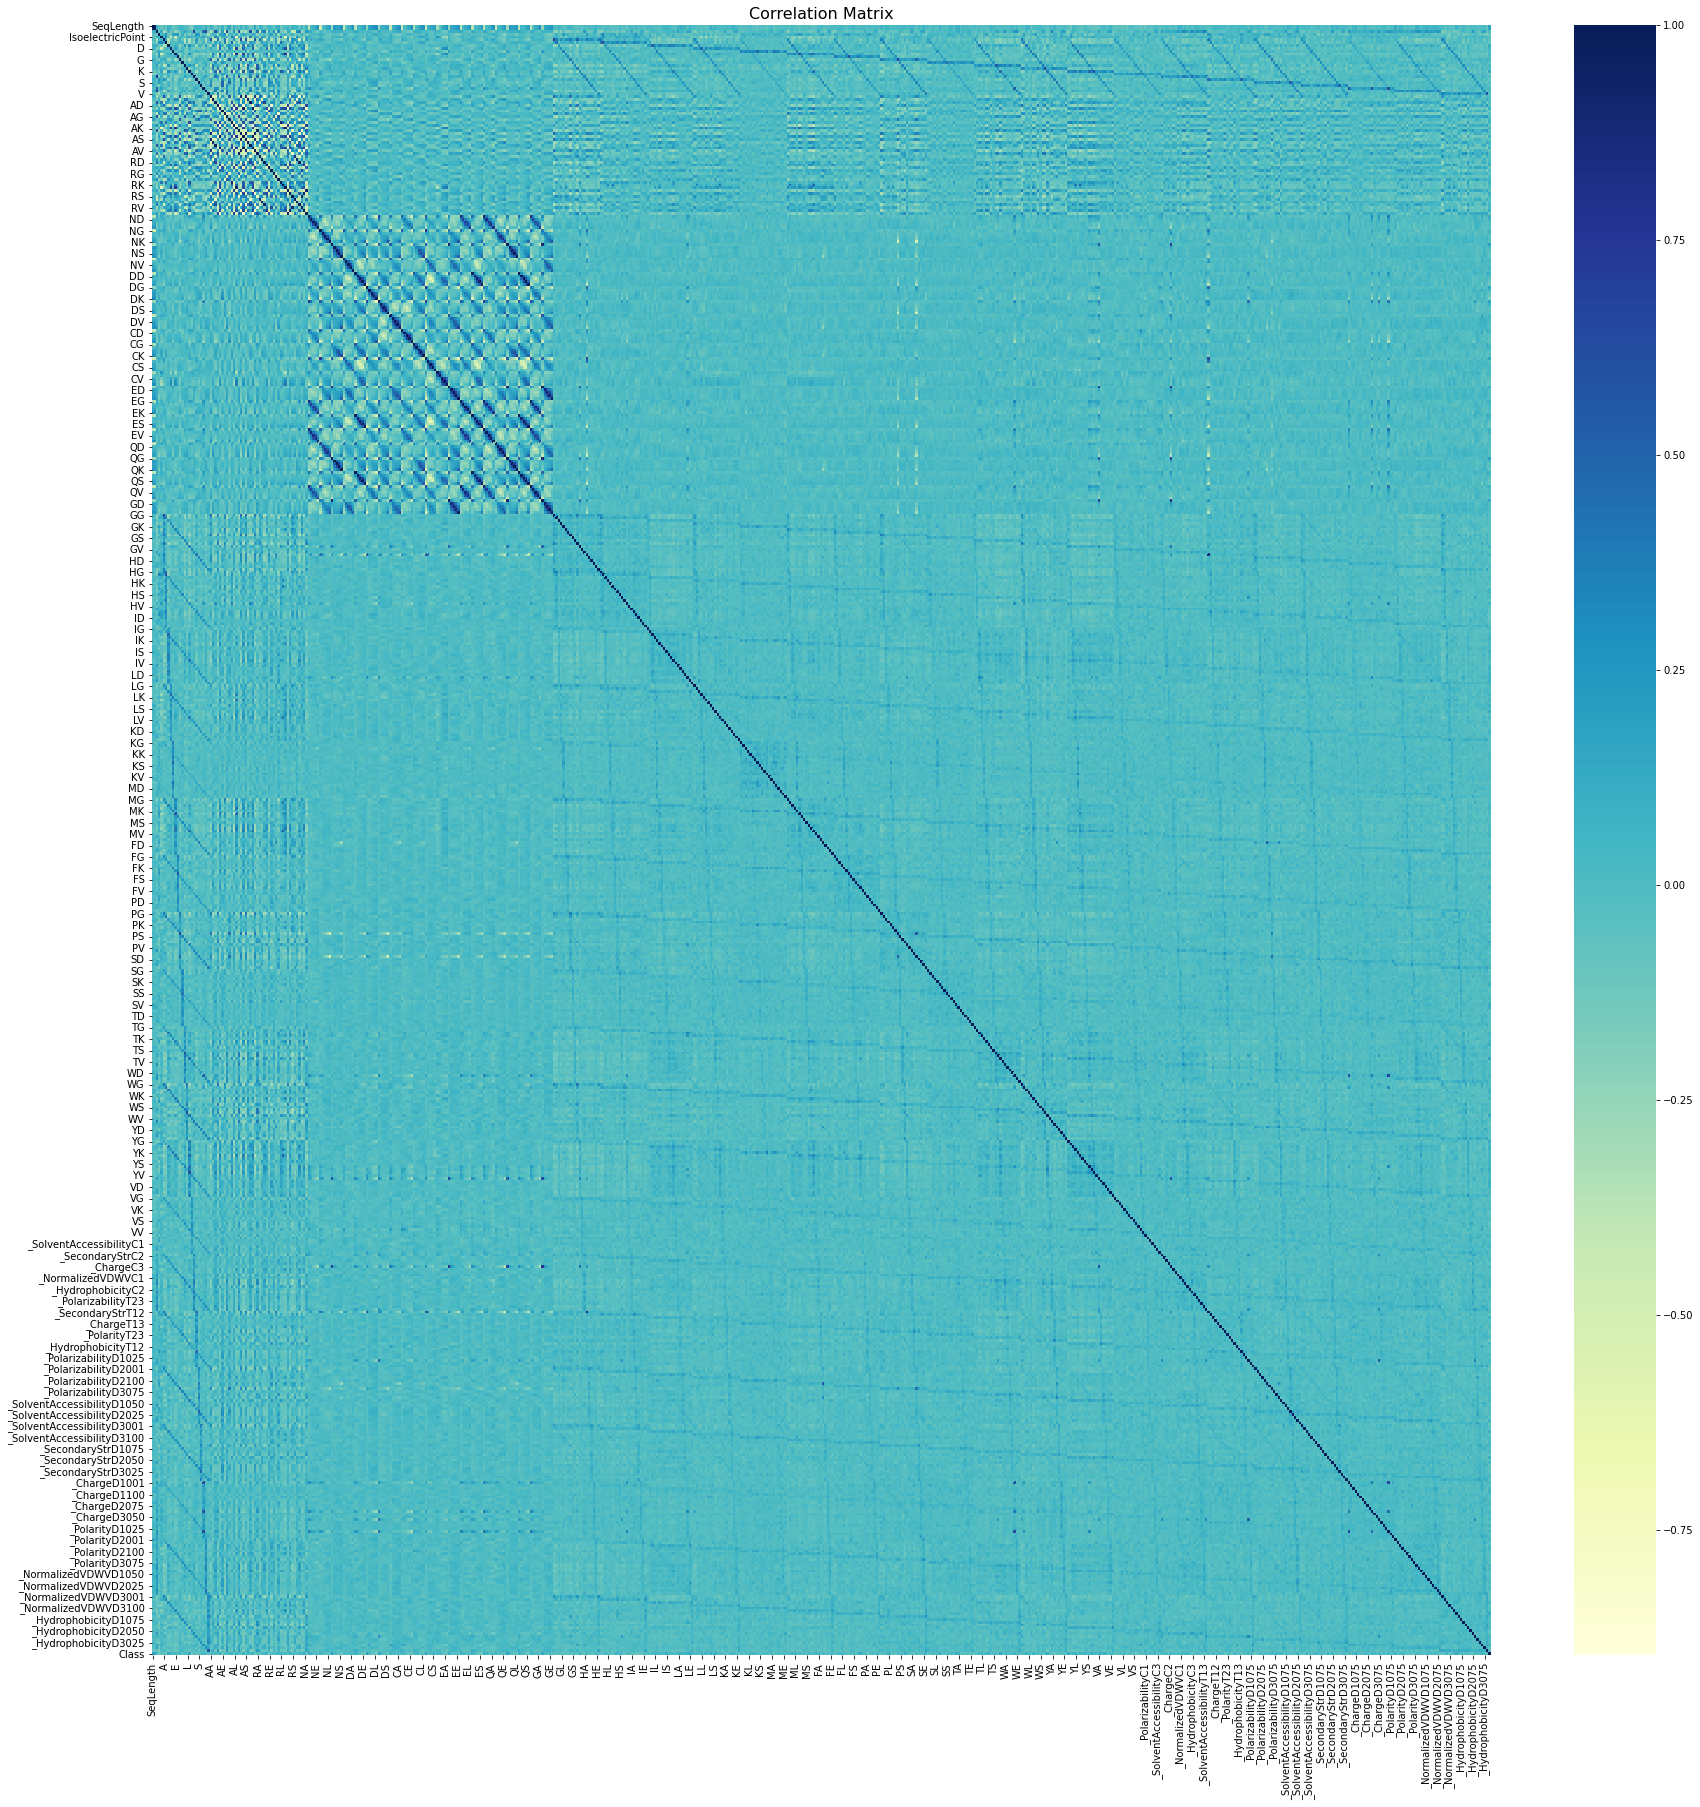

In [ ]:
plt.subplots(figsize=(30, 30))
sns.heatmap(peptideDf.corr(), cmap="YlGnBu")

plt.title('Correlation Matrix', fontsize=16);
plt.show()

In [ ]:
# Looking at the dictionary containing feature names
for setName in featureNames.keys():
  print(f'{setName:7}:{len(featureNames[setName])}')

primary:5
AAC    :20
CTD    :147
DPC    :400


**Figure 1 - Correlation Matrix of All features**

*Observation*
- Since we have large number of features it is difficult to visualize the correlation. But we can see two square patterns in correlation of features. In any case, let us look at each feature sets separately.

***
[sns.heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)
[matshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.matshow.html)



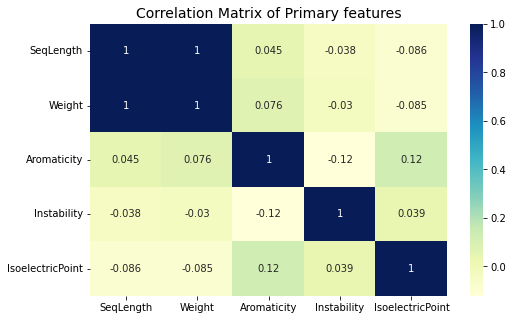

In [ ]:
# Plotting Primary features
f = plt.figure(figsize=(8, 5))
sns.heatmap(peptideDf[featureNames['primary']].corr(), cmap="YlGnBu", annot=True)

plt.title('Correlation Matrix of Primary features', fontsize=14);
plt.show()

**Figure 2 - Correlation Matrix of Primary features**

*Observation*
- We can see that the sequence length and weight are highly correlated. This makes sense because increase in sequence length means adding more amino acid which in turn will increase the molecular weight of the protein.
- The correlation between the rest of the features are not more than 10%, this indicates that these features are independent to each other.


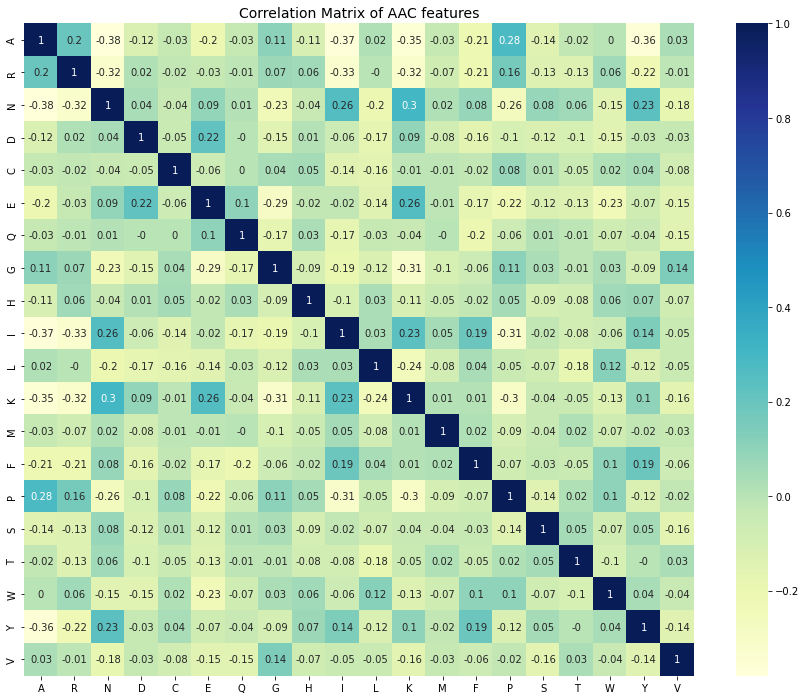

In [ ]:
# Plotting Amino Acid Composition features
f = plt.figure(figsize=(15, 12))
sns.heatmap(round(peptideDf[featureNames['AAC']].corr(),2), cmap="YlGnBu", annot=True)    # rounding the correlation values to 2 decimal points

plt.title('Correlation Matrix of AAC features', fontsize=14);
plt.show()

**Figure 3 - Correlation Matrix of Primary features**

*Observation*
- No two features have more than 45% of correlation (on both positive and negative relationship).
- This indicates, in Amino Acid Composition none of the amino acids are highly correlated.

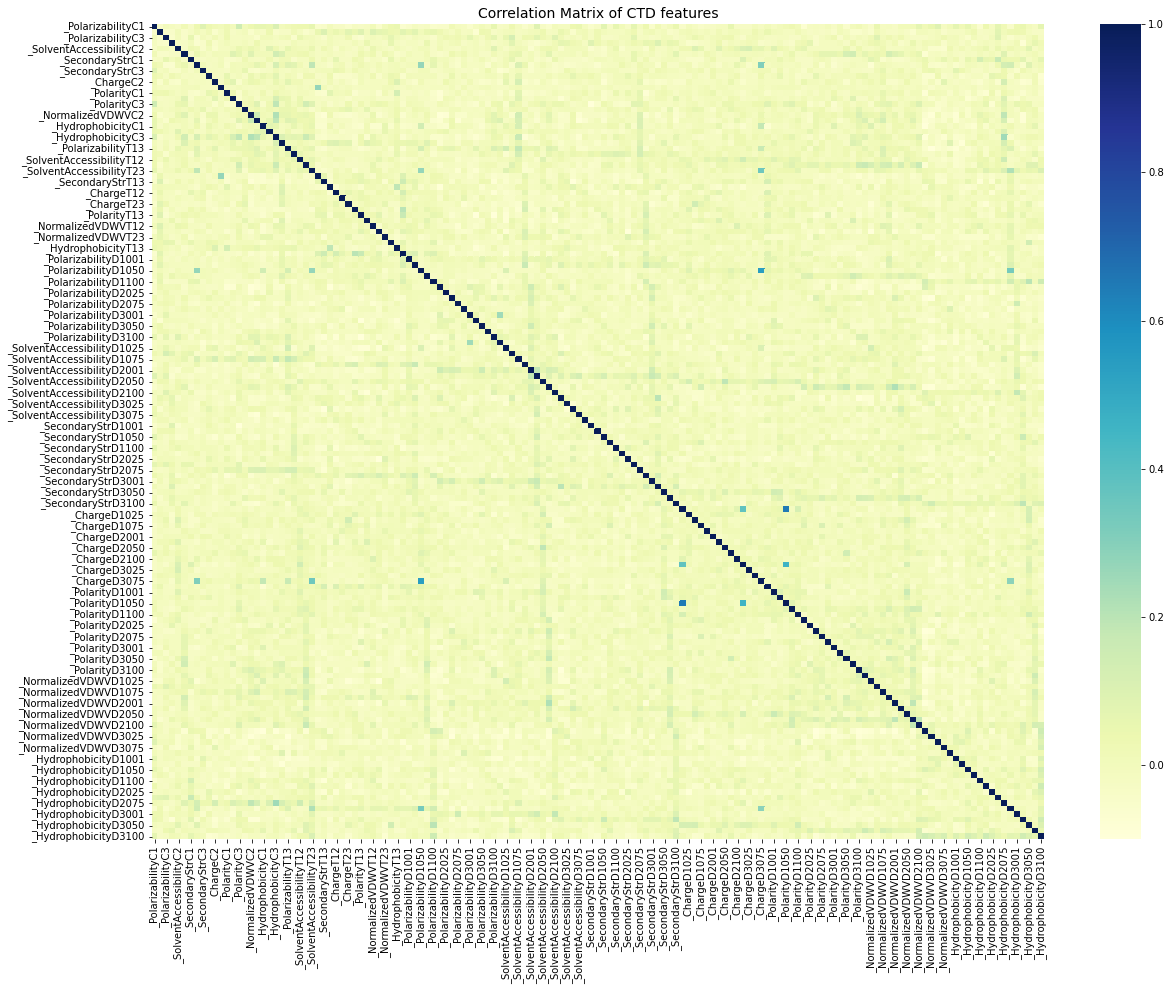

In [ ]:
# Plotting Composition Transition and Distribution features
f = plt.figure(figsize=(20, 15))
sns.heatmap(round(peptideDf[featureNames['CTD']].corr(),2), cmap="YlGnBu")    # rounding the correlation values to 2 decimal points

plt.title('Correlation Matrix of CTD features', fontsize=14);
plt.show()

**Figure 3 - Correlation Matrix of Primary features**

*Observation*
- From the correlation matrix it looks like we don't have any highly correlated features.
- As the number of features is high, it is difficult to check for highly correlated features

*Sol: Show only the features with high correlation*

In [ ]:
# Get highly correlated features on either side for CTD
highCorrCTD = peptideDf[featureNames['CTD']].corr()
highCorrCTD = highCorrCTD[(abs(highCorrCTD) > 0.9) & (abs(highCorrCTD) != 1)]

if highCorrCTD.notna().values.any() == False:
  print('No two features are highly correlated in CTD')

No two features are highly correlated in CTD


In [ ]:
# Get highly correlated features on either side for DPC
highCorrDPC = peptideDf[featureNames['DPC']].corr()
highCorrDPC = highCorrDPC[(abs(highCorrDPC) > 0.9) & (abs(highCorrDPC) != 1)]

if highCorrDPC.notna().values.any() == False:
  print('No two features are highly correlated in DPC')
else:
  print('There are highly correlated features in DPC')

# Get correlation matrix of the selected features table
highCorrDPC = highCorrDPC.where(np.triu(np.ones(highCorrDPC.shape), k=1).astype(bool)).stack().reset_index()
highCorrDPC.rename(columns={'level_0':'feature 1', 'level_1':'feature 2', 0:'Correlation'}, inplace=True)
highCorrDPC

There are highly correlated features in DPC


feature 1 feature 2  Correlation
0         AA        AS     0.921221
1         AC        AP     0.977932
2         AK        RM     0.911480
3         AM        RA     0.957539
4         AF        AS     0.930662
5         AF        AV     0.938509
6         AP        AY     0.977932
7         RN        RW     0.919148
8         RD        RY     0.938063
9         RF        NR     0.927635
10        RP        NA     0.946230
11        RS        RV     0.910225
12        NN        EW     0.914100
13        DN        EM     0.978645
14        DD        EF     0.912466
15        DC        EP     0.919400
16        DE        ES     0.930717
17        DQ        ET     0.978305
18        EN        GN     0.995720
19        EQ        GQ     0.959428
20        EG        EW     0.911114
21        EG        QW     0.929501
22        EM        QM     0.978645
23        EF        QF     0.912466
24        EP        QP     0.919400
25        ES        QS     0.930717
26        ET        QT     0.978305
27        EW        QW     0.903309

[correlation_matrix_transform](https://python-forum.io/thread-15071.html)

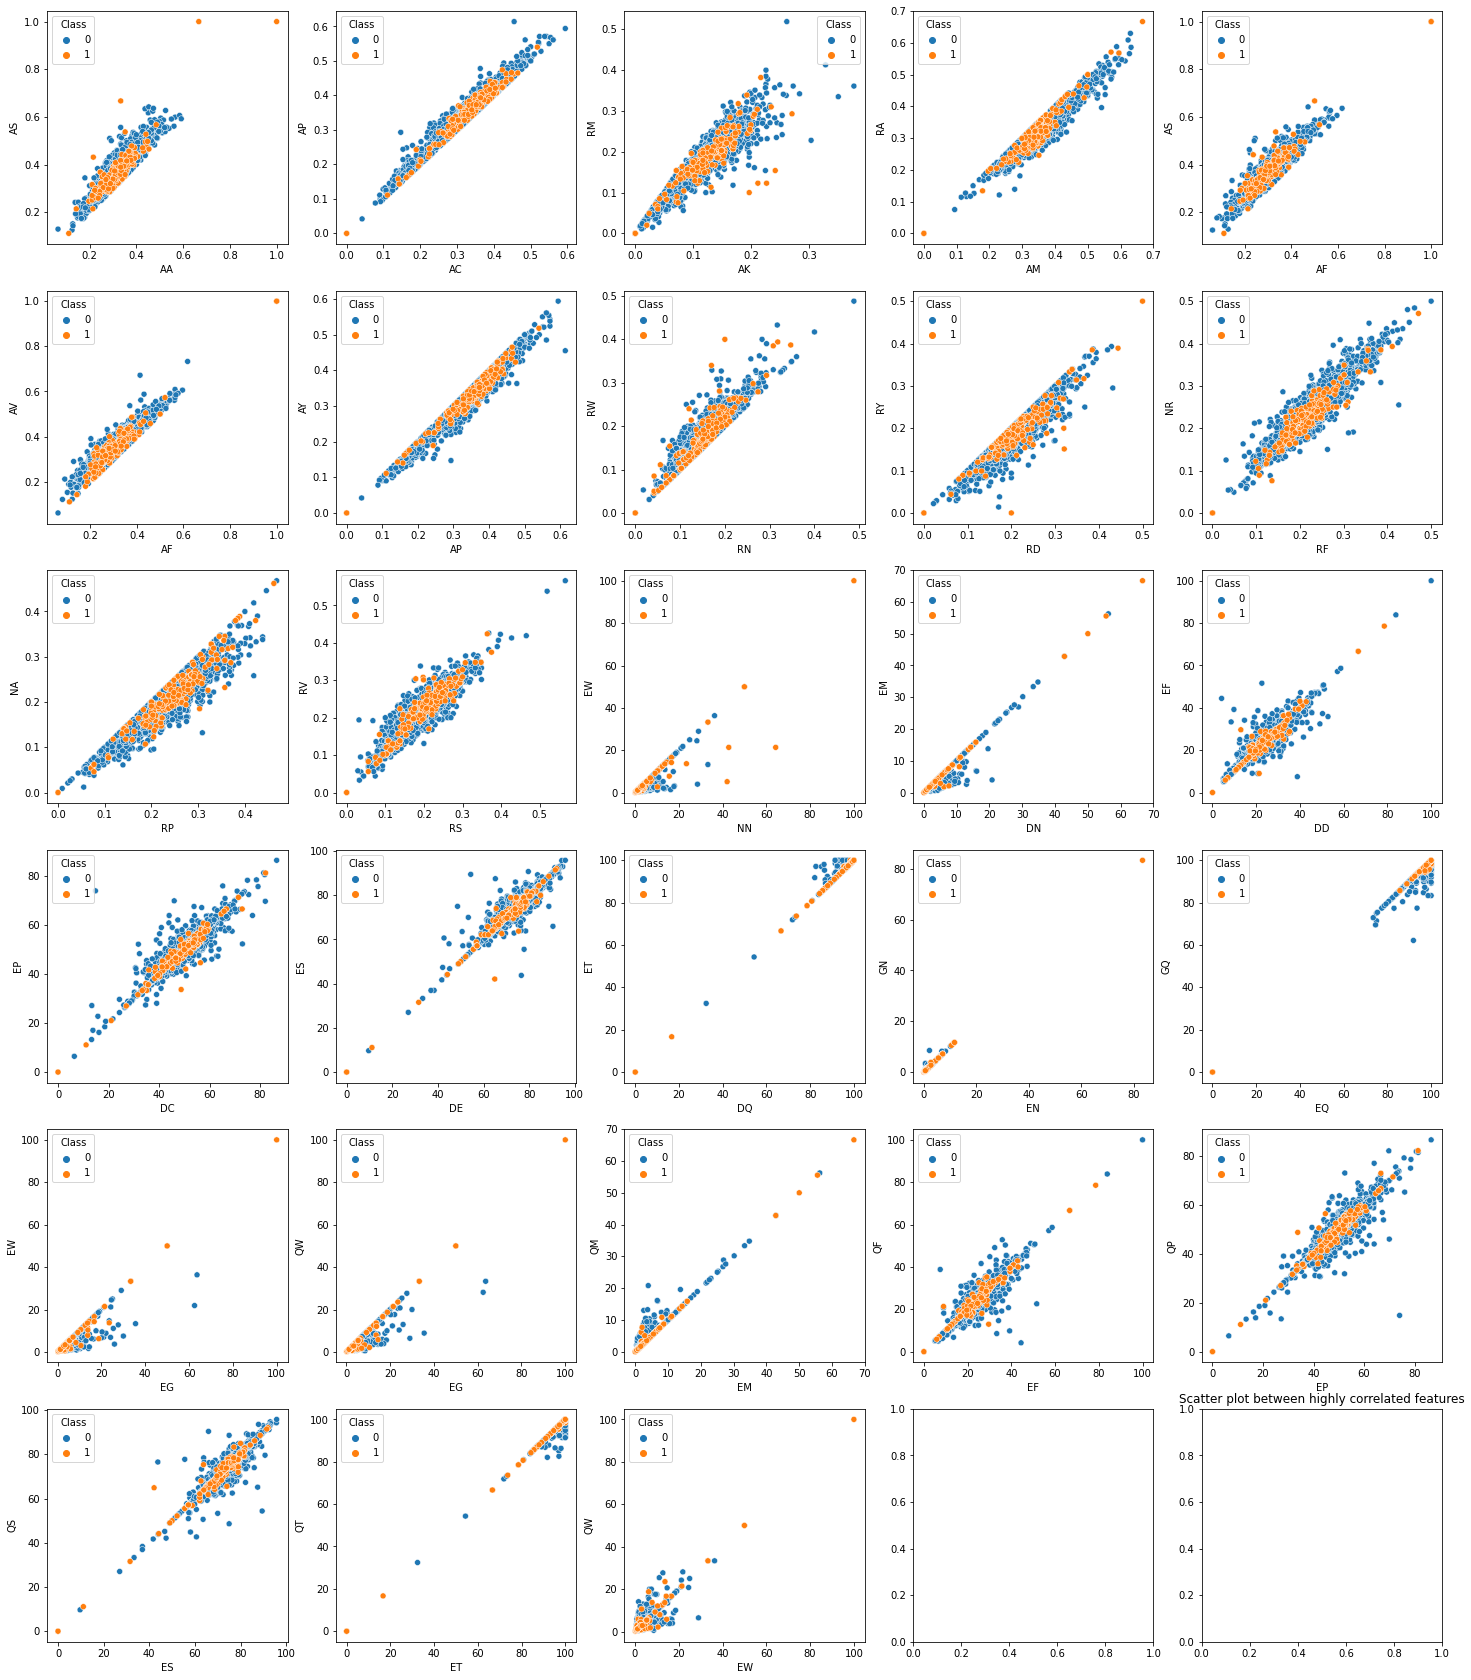

In [ ]:
# scatter plot between highly correlated features
ax = []
for i in range(0,6):
    for j in range(0,5):
        ax.append([i,j])

fig, axes = plt.subplots(6,5,figsize=(25,30))
for i in range(28):
  x,y = ax[i]
  sns.scatterplot(data = peptideDf, x=peptideDf[highCorrDPC['feature 1'][i]], y=peptideDf[highCorrDPC['feature 2'][i]], hue = 'Class', ax=axes[x,y])
plt.title('Scatter plot between highly correlated features')
plt.show()

In [ ]:
# Saving highly correlated features in json file

corr_features_to_remove = list(highCorrDPC['feature 1'])
corr_features_to_remove.append('Weight')       # Adding Weight

In [ ]:
# save the highly correlated features in the json file
with open("/content/drive/Shareddrives/Interview Prep/proteins/corr_features_to_remove.json", "w") as outfile:
    json.dump(corr_features_to_remove, outfile)

## Distributions

Number of features :  5



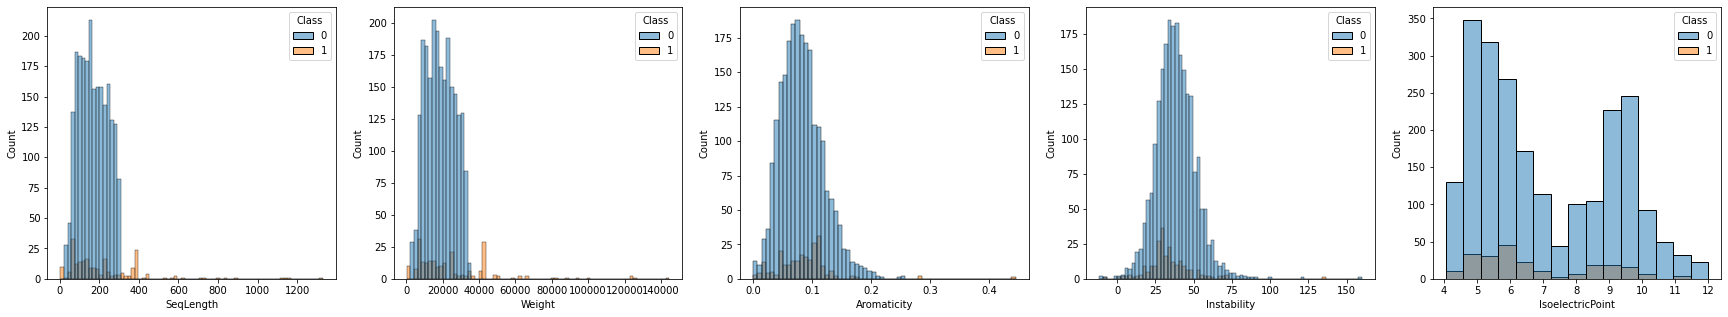

In [ ]:
# reset peptideDf index
peptideDf.reset_index(level=0, inplace=True)

# Distribution of primary features
primaryFeatures = featureNames['primary']
length = len(primaryFeatures)
print('Number of features : ',length)
print()

fig, axes = plt.subplots(1,5,figsize=(30,5))
for i in range(length):
  hist = sns.histplot(peptideDf, x=primaryFeatures[i], hue='Class', ax=axes[i])
plt.show()

**Figure 5 - Histogram of primary features for both classes**

*Observation*
- Sequence Length has most of its values below 2000.
- Weight has most of its values below 0.2.
  *Note: Seqlence length and weight are highly correlated thus have similar distributions*
- Aromaticity is normally distributed for both the classes but the centre of positive peptides are shifted slightly towards right.
- Instability is normally distributed for both the classes. Also they are equally centered.
- Isoelectric Point is distributed bimodally.

*Sol: Remove peptides having sequence length above 2000*

[Biomodal Distributions] (https://www.statisticshowto.com/what-is-a-bimodal-distribution/)

Number of features :  20



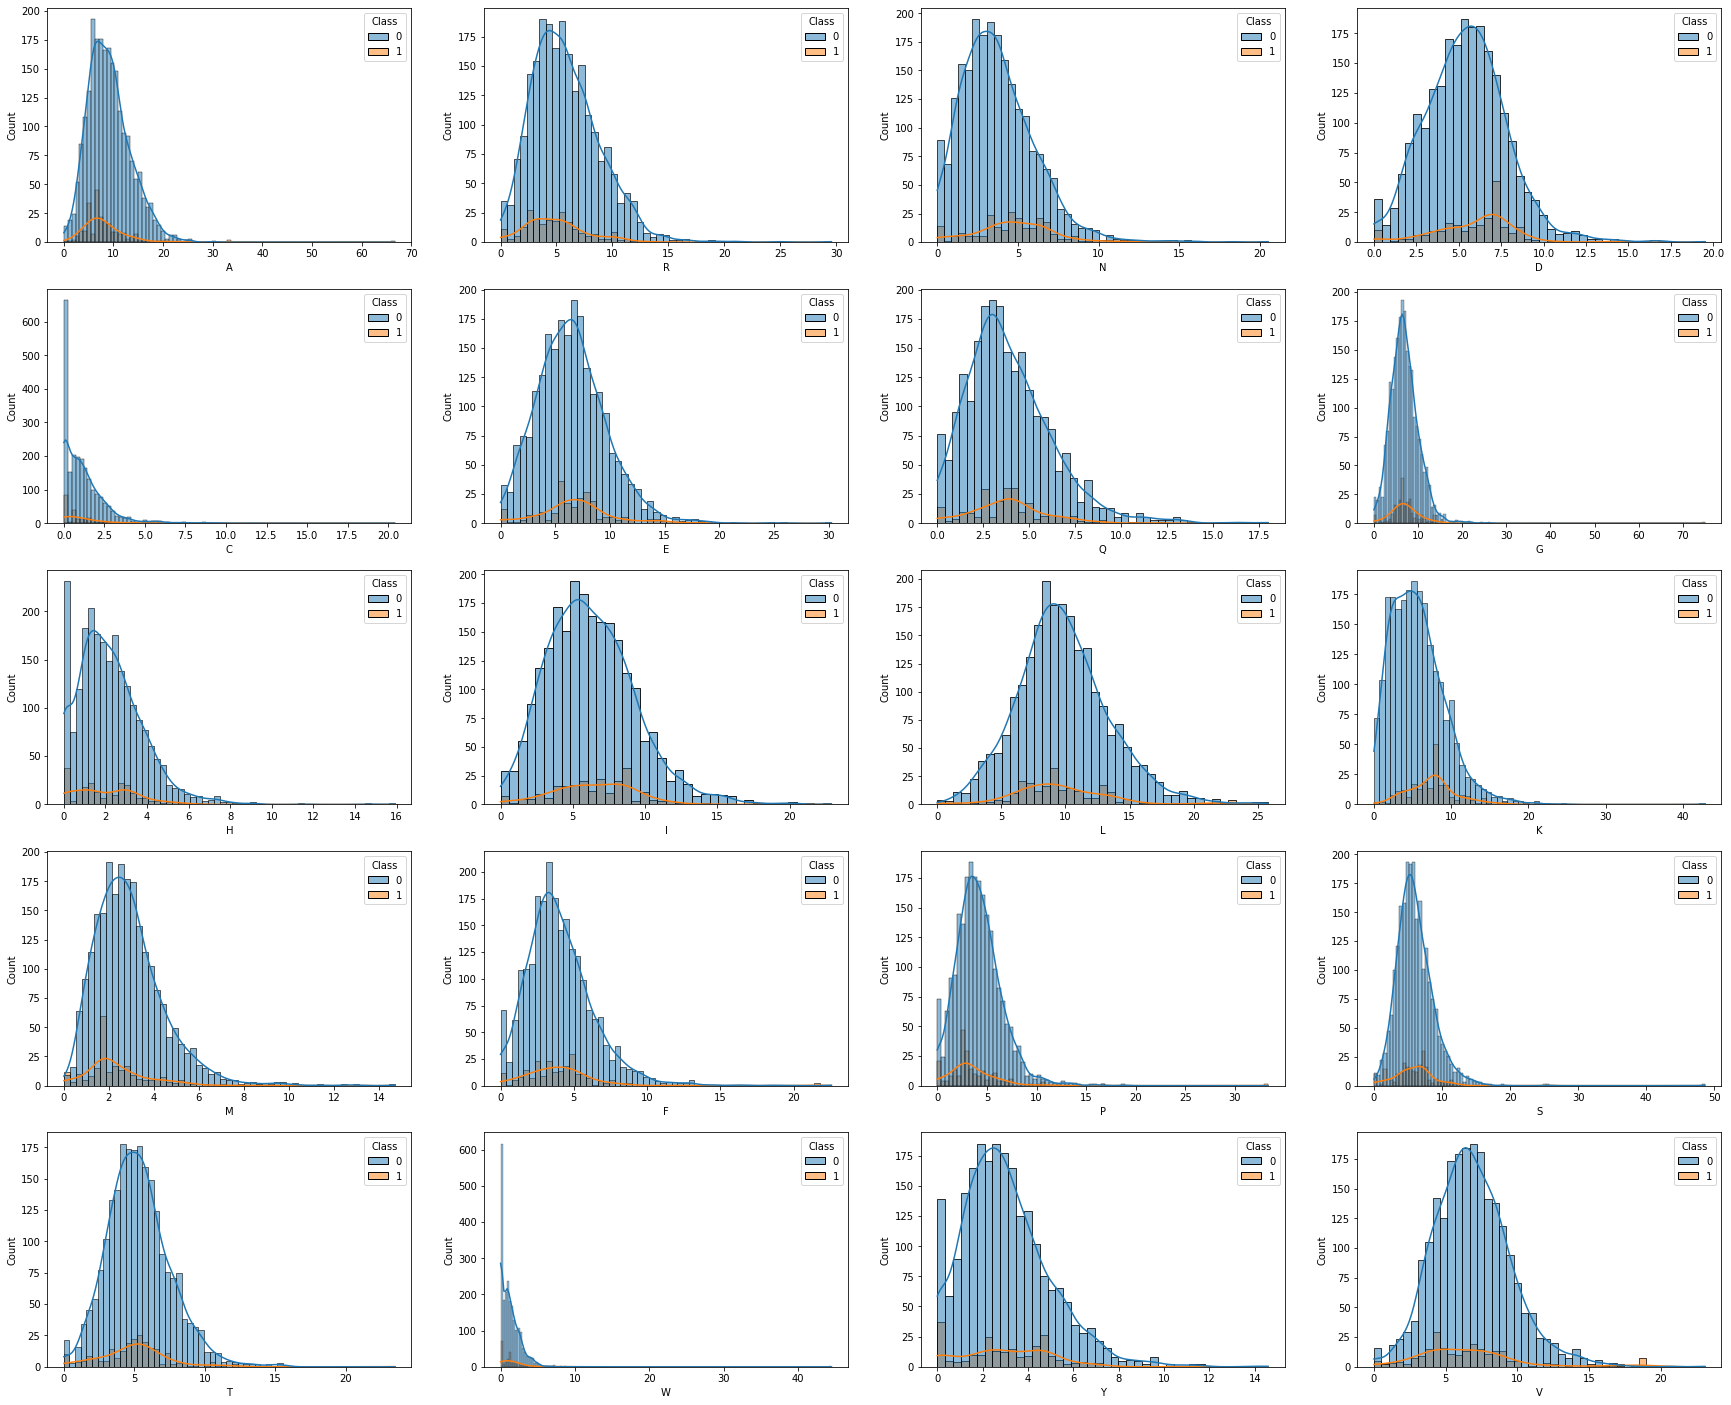

In [ ]:
# Distribution of AAC features
AACFeatures = featureNames['AAC']
length = len(AACFeatures)
print('Number of features : ',length)
print()

ax = []
for i in range(0,5):
    for j in range(0,4):
        ax.append([i,j])

fig, axes = plt.subplots(5,4,figsize=(30,25))
for i in range(length):
  x,y = ax[i]
  sns.histplot(peptideDf, x=AACFeatures[i], hue='Class', ax=axes[x,y], kde=True)
plt.show()

**Figure 6 - Histogram of AAC features for both classes**

*Observation*
- Most of the AAC features are distributed normally.
- Also, for most features, the distributions are similar and equally centered except A, I, P, Y, V where we can see clear distinction.

Number of features :  400



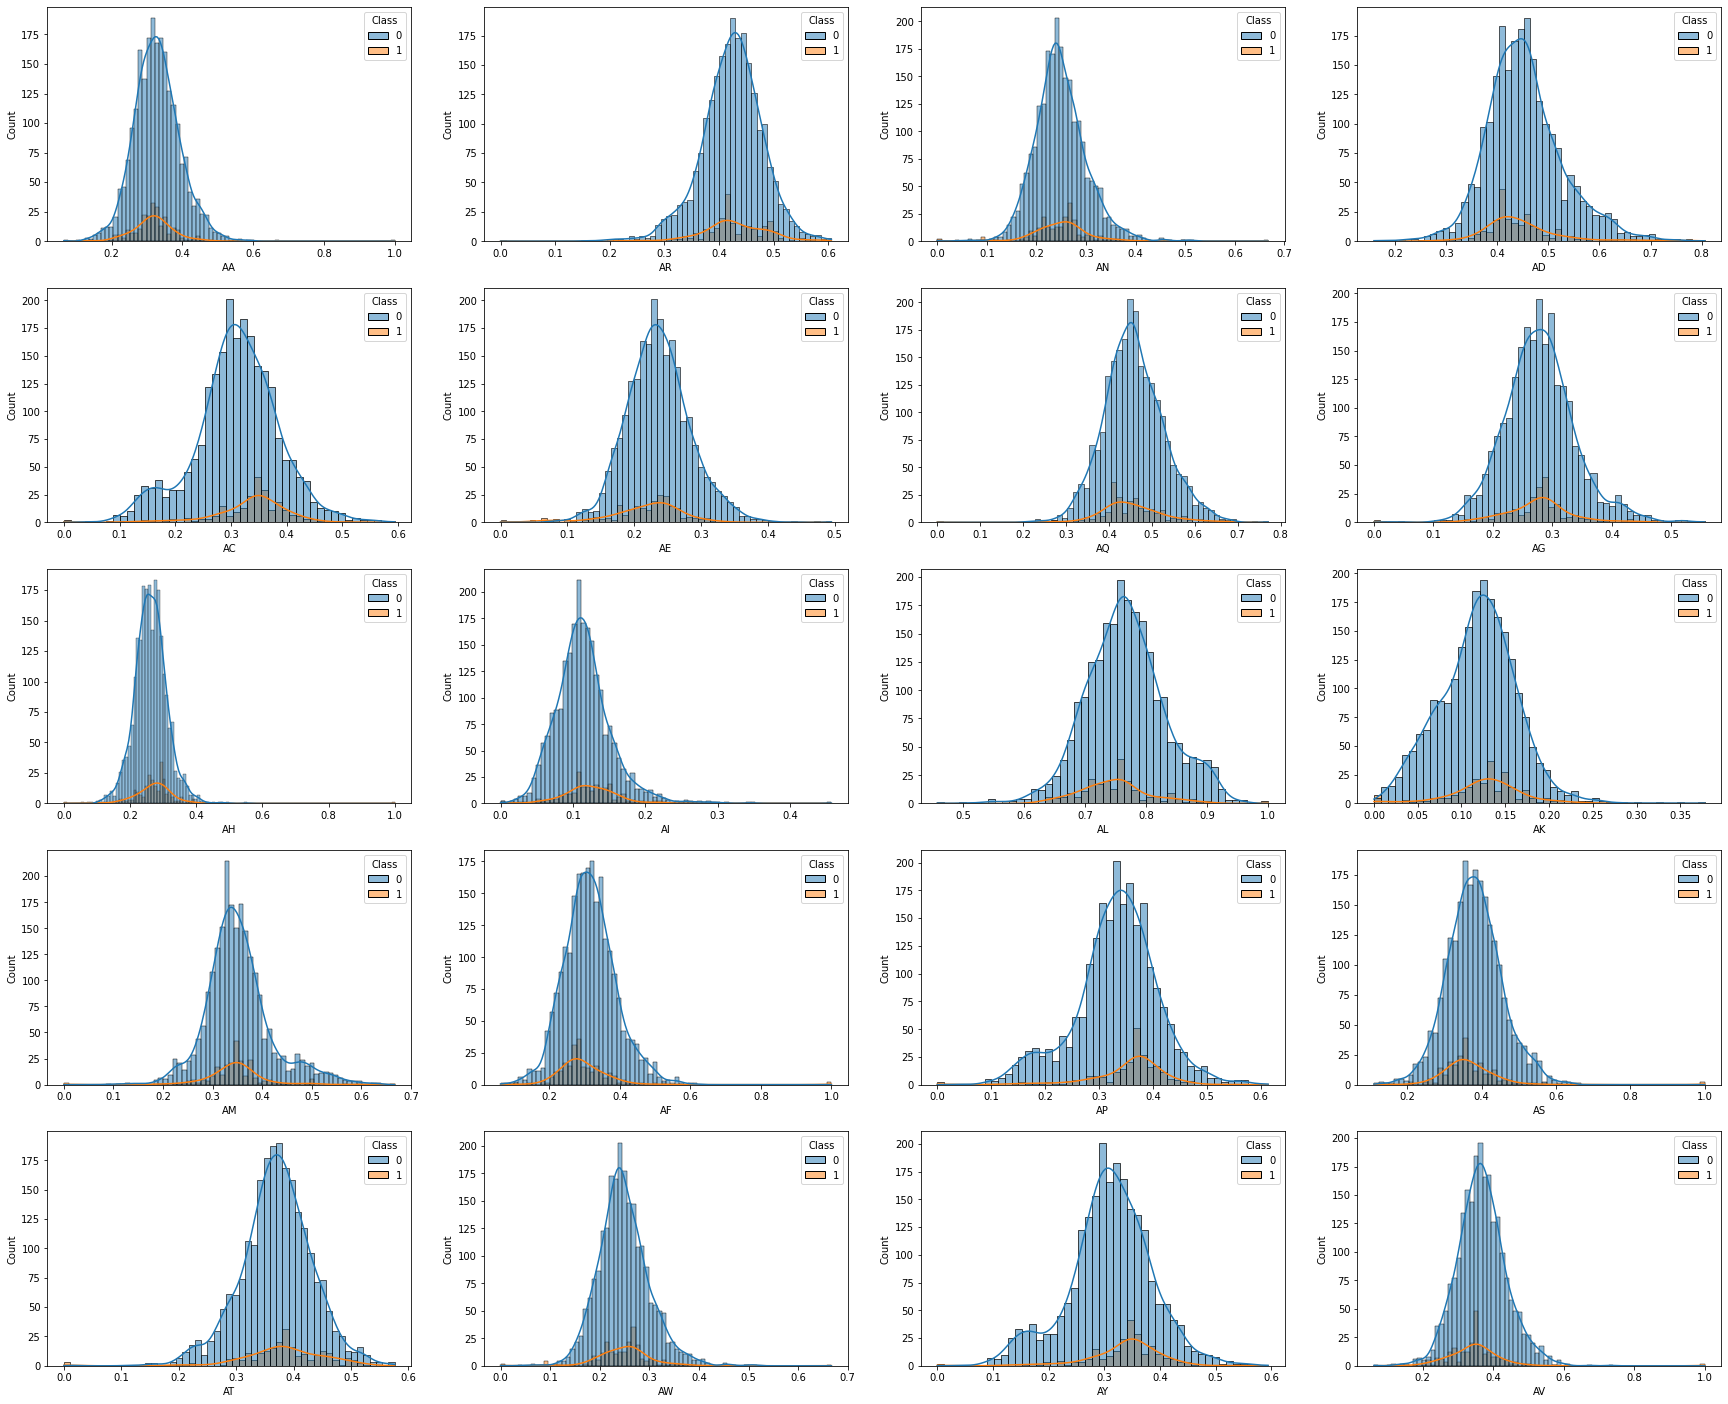

In [ ]:
# Distribution of few DPC features
DPCFeatures = featureNames['DPC']
length = len(DPCFeatures)
print('Number of features : ',length)
print()

ax = []
for i in range(0,5):
    for j in range(0,4):
        ax.append([i,j])

fig, axes = plt.subplots(5,4,figsize=(30,25))
for i in range(len(ax)):
  x,y = ax[i]
  sns.histplot(peptideDf, x=DPCFeatures[i], hue='Class', ax=axes[x,y], kde=True)
plt.show()

**Figure 7 - Histogram of DPC features for both classes**

*Observation*
- Most of the DPC features are distributed normally.
- Also, for most features, the distributions are similar and equally centered except AD, AC, AF, AP, AY, AV where we can see clear distinction.

Number of features :  147



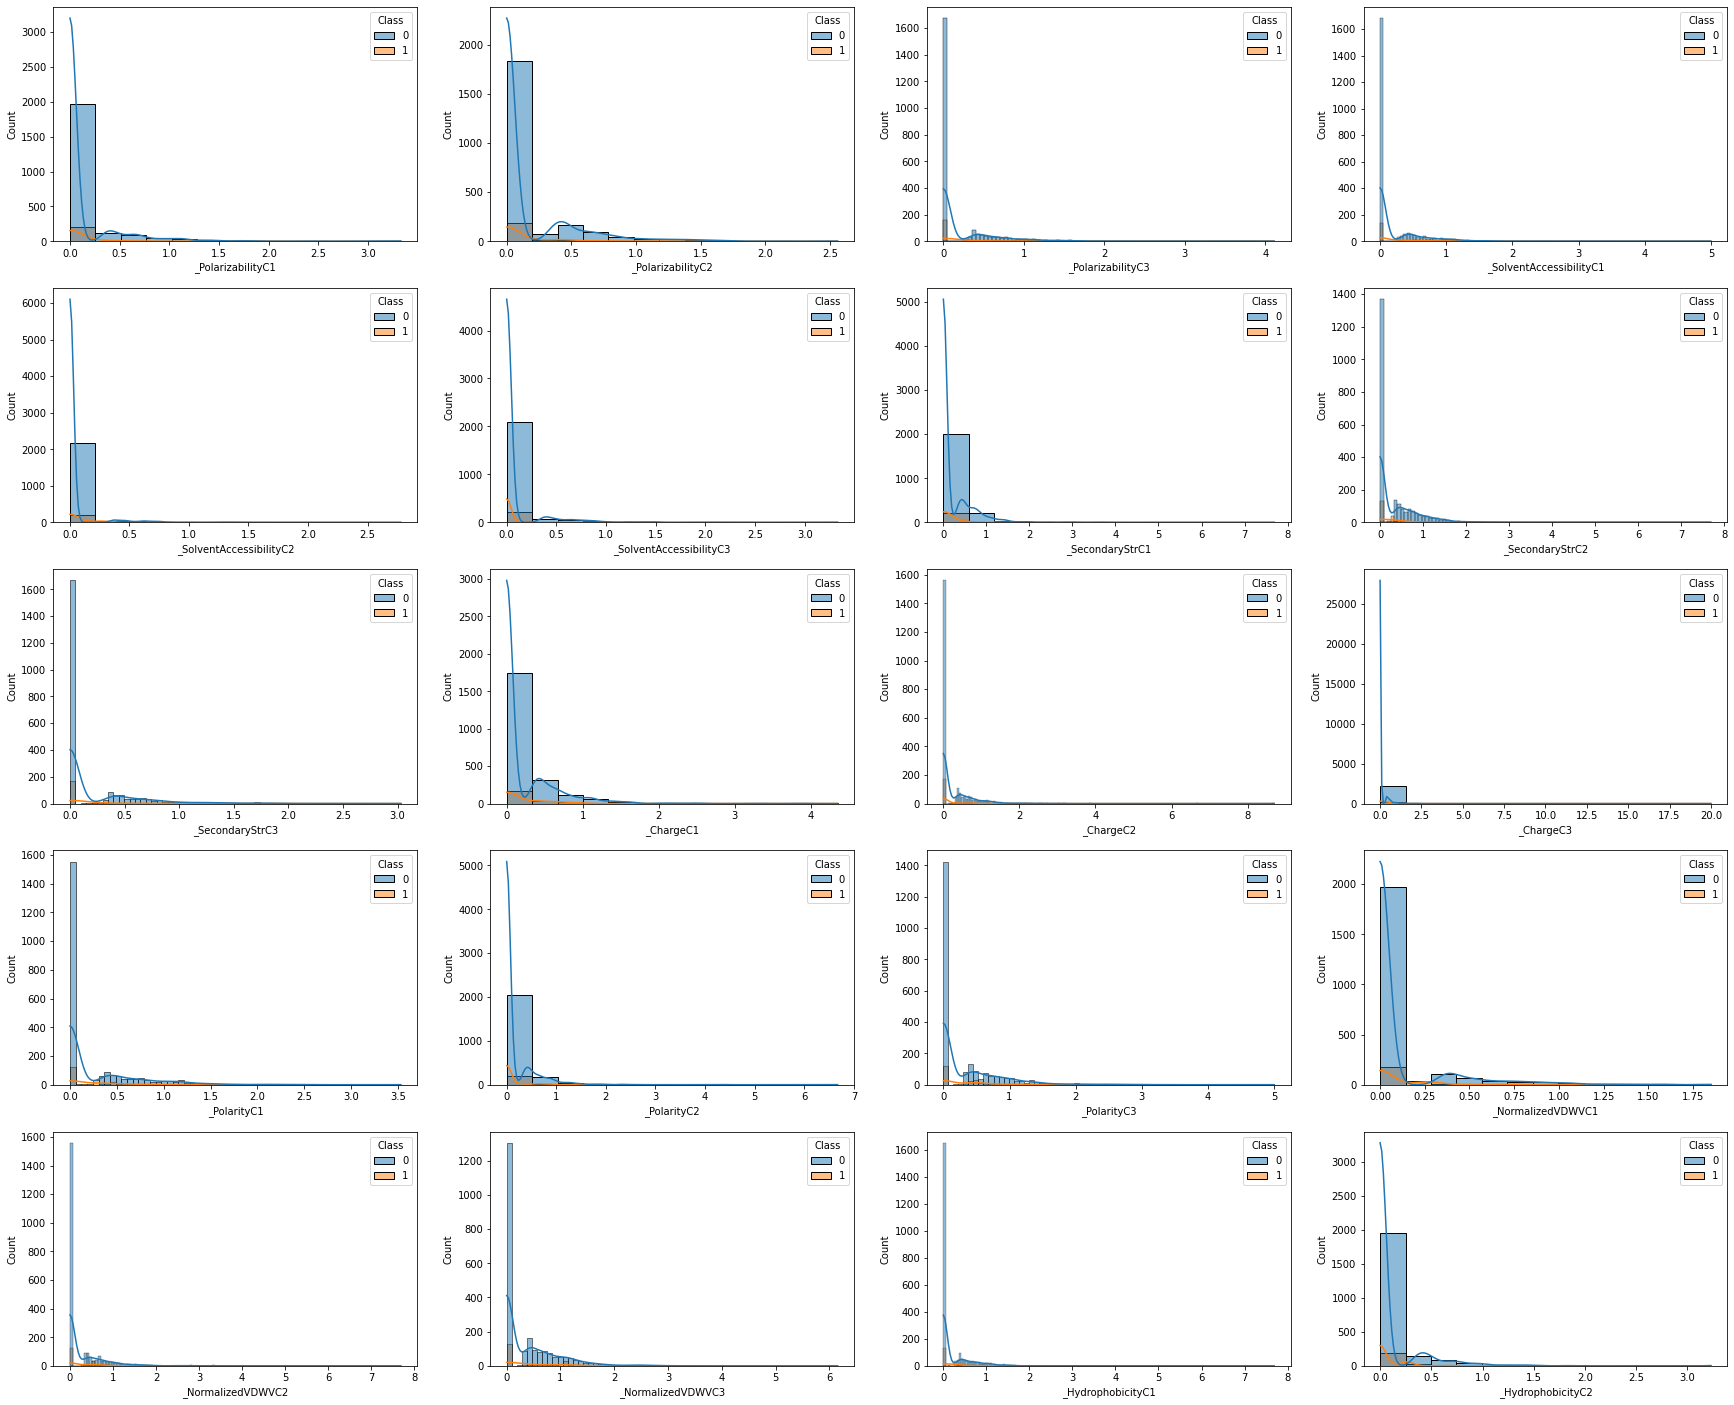

In [ ]:
# Distribution of AAC features
CTDFeatures = featureNames['CTD']
length = len(CTDFeatures)
print('Number of features : ',length)
print()

ax = []
for i in range(0,5):
    for j in range(0,4):
        ax.append([i,j])

fig, axes = plt.subplots(5,4,figsize=(30,25))
for i in range(len(ax)):
  x,y = ax[i]
  sns.histplot(peptideDf, x=CTDFeatures[i], hue='Class', ax=axes[x,y], kde=True)
plt.show()

**Figure 8 - Histogram of DPC features for both classes**

*Observation*
- Most of the AAC features are right skewed.
- Also, we can see, a large number of peptides has zero values for these features.

## Percentage Composition

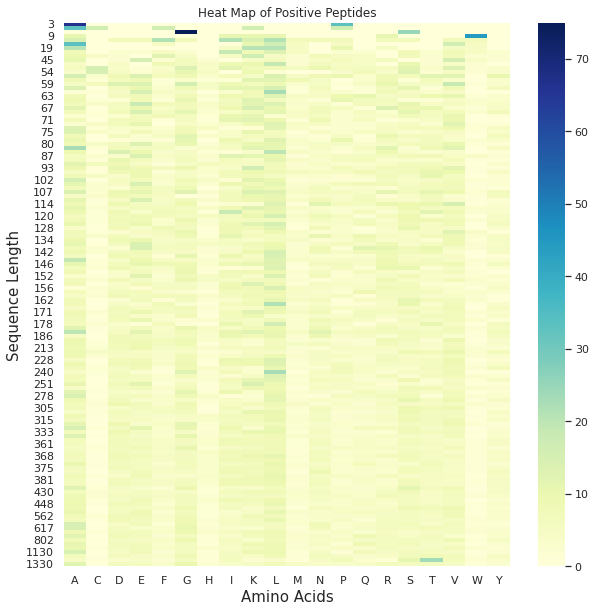

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Transform to visualize occurances of each peptide in sequences
aa_seq = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
AAdf = positiveDf[aa_seq]
AAdf['SeqLength'] = positiveDf['SeqLength']
AAdf[aa_seq].div(AAdf.SeqLength, axis=0)
AAdf = AAdf.sort_values('SeqLength')

aa_seq_df = pd.DataFrame(columns=['SeqLength','Composition','amino_acid'])
aa_df = pd.DataFrame(columns=['SeqLength','Composition','amino_acid'])

for i in aa_seq:
    aa_seq_df['SeqLength'] = AAdf['SeqLength']
    aa_seq_df['amino_acid'] = i
    aa_seq_df['Composition'] = AAdf[i]
    aa_df = pd.concat([aa_df,aa_seq_df],ignore_index=True)

aa_df = aa_df.sort_values('Composition', ascending=False).drop_duplicates(['SeqLength','amino_acid'])

# Create long format
seq = aa_df['SeqLength']
feature = aa_df['amino_acid']
value = aa_df['Composition']
df = pd.DataFrame({'feature': feature, 'seq': seq, 'value': value })

dfe = df[df['feature'] == 'E']
dfe.sort_values('seq').head(10)

seq = aa_df['SeqLength']
feature = aa_df['amino_acid']
value = aa_df['Composition']

# Turn long format into a wide format
df_wide = df.pivot_table( index='seq', columns='feature', values='value')

# plot it
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(df_wide, cmap="YlGnBu")
plt.title('Heat Map of Positive Peptides')
plt.ylabel('Sequence Length',fontsize=15)
plt.xlabel('Amino Acids',fontsize=15)
plt.show()

**Figure 9 - Composition of each Amino Acid in positive class**

*Observation*
- The percentage of amino acid L and S occurs more in Positive Peptides.

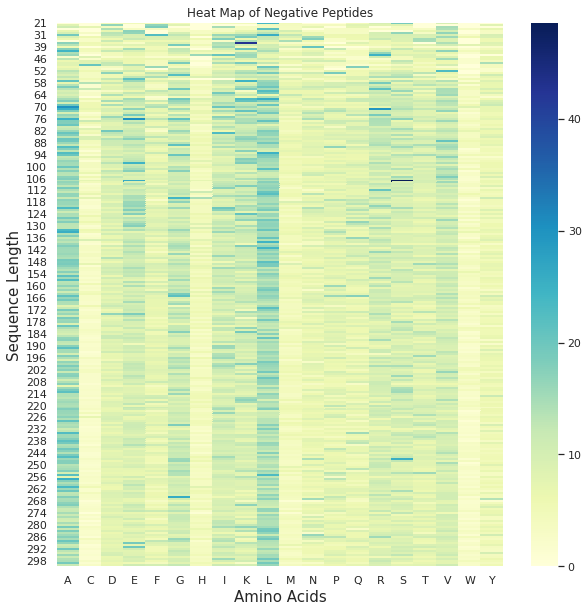

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Transform to visualize occurances of each peptide in sequences
aa_seq = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
AAdf = negativeDf[aa_seq]
AAdf['SeqLength'] = negativeDf['SeqLength']
AAdf[aa_seq].div(AAdf.SeqLength, axis=0)
AAdf = AAdf.sort_values('SeqLength')

aa_seq_df = pd.DataFrame(columns=['SeqLength','Composition','amino_acid'])
aa_df = pd.DataFrame(columns=['SeqLength','Composition','amino_acid'])

for i in aa_seq:
    aa_seq_df['SeqLength'] = AAdf['SeqLength']
    aa_seq_df['amino_acid'] = i
    aa_seq_df['Composition'] = AAdf[i]
    aa_df = pd.concat([aa_df,aa_seq_df],ignore_index=True)

aa_df = aa_df.sort_values('Composition', ascending=False).drop_duplicates(['SeqLength','amino_acid'])

# Create long format
seq = aa_df['SeqLength']
feature = aa_df['amino_acid']
value = aa_df['Composition']
df = pd.DataFrame({'feature': feature, 'seq': seq, 'value': value })

dfe = df[df['feature'] == 'E']
dfe.sort_values('seq').head(10)

seq = aa_df['SeqLength']
feature = aa_df['amino_acid']
value = aa_df['Composition']

# Turn long format into a wide format
df_wide = df.pivot_table( index='seq', columns='feature', values='value')

# plot it
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(df_wide, cmap="YlGnBu")
plt.title('Heat Map of Negative Peptides')
plt.ylabel('Sequence Length',fontsize=15)
plt.xlabel('Amino Acids',fontsize=15)
plt.show()

**Figure 10 - Composition of each Amino Acid in negative class**

*Observation*
- The percentage of amino acids A,G,V along with L and S are more in Negative Peptides.